### Mount drive and import libraries

In [1]:
# Uncomment if pysteps is not installed
!pip install pysteps

from google.colab import drive
drive.mount('/content/drive/')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset
from torch.utils.data import ConcatDataset
from pysteps.utils import spectral
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import kagglehub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jsmin-3.0.1-py3-none-any.whl
  Created wheel for pysteps: filename=pysteps-1.13.0-cp310-cp310-linux_x86_64.whl size=1484063 sha256=9044583d93930e666ea96ee91aaba5b2c012ee58061c1d5af782f5ab34682ff2
  Stored in directory: /root/.cache/pip/wheels/99/3f/28/d628b2f6760329df4cdd8a6498b5e50a4d78f9c65a2591fe4f
Successfully built pysteps
Mounted at /content/drive/
Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



### Move to GPU

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Using device: cuda


### Parameters

In [3]:
# To be modified or enhanced
batch_size = 32
num_epochs = 2
learning_rate = 0.001
rapsd_dim = 112*3
n_classes = 2


### Functions

In [4]:
# Function to prepare image for fft
def prepare_image_for_fft(image):

    # Convert to numpy array
    image_np = image.cpu().numpy()
    return image_np

In [5]:
def compute_rapsd_subset(subset):
    """
    Computes RAPSD for a subset of images.

    Parameters:
    - subset: List or dataset of (image, label) pairs.

    Returns:
    - List of merged RAPSD features for each image.
    - List of frequency arrays for each image.
    """
    rapsd_subset = []
    frequencies_subset = []

    # For all images in subset
    for img, _ in subset:
        rapsd_features = []  # To store per-channel RAPSD for one image
        frequencies_list = []  # To store per-channel frequencies for one image

        # Iterate over each of the three channels (RGB)
        for i in range(img.shape[0]):  # Assuming the image is 3xHxW (3 channels)
            # Prepare the image
            prepared_image = prepare_image_for_fft(img[i])

            # Compute RAPSD
            rapsd, frequencies = spectral.rapsd(prepared_image, fft_method=np.fft, return_freq=True)
            rapsd_features.append(rapsd)
            frequencies_list.append(frequencies)

        # Merge RAPSD features for all channels of one image
        merged_rapsd = np.concatenate(rapsd_features, axis=0)  # Combine RAPSD features for all channels
        merged_frequencies = np.array(frequencies_list[0])  # Use frequencies from the first channel (identical)

        # Append per-image results
        rapsd_subset.append(merged_rapsd)
        frequencies_subset.append(merged_frequencies)

    return rapsd_subset, frequencies_subset


In [6]:
def accuracy(target, pred):
  target = target.detach().cpu().numpy()
  pred = pred.detach().cpu().numpy()
  return metrics.accuracy_score(target, pred)

In [7]:
def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

### Image preprocessing

In [ ]:
# Uncomment if kagglehub is not installed
#!pip install kagglehub


In [ ]:
#!ls /content/drive/MyDrive/SharedFolder

In [8]:

# Define paths (For Viktor)
#synthetic_path = '/content/drive/MyDrive/Project18/synthetic'
#real_path = '/content/drive/MyDrive/Project18/real'

# (For Rest) To do: Add a shortcut of the folder "Project18" to Drive,
# place the shortcut folder inside a folder called "SharedFolder"
synthetic_path = '/content/drive/MyDrive/SharedFolder/Project18/synthetic'
real_path = '/content/drive/MyDrive/SharedFolder/Project18/real'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load datasets with ImageFolder
synthetic_dataset = datasets.ImageFolder(root=synthetic_path, transform=transform)
real_dataset = datasets.ImageFolder(root=real_path, transform=transform)

# Custom Dataset Wrapper for Binary Classification
class BinaryLabelDataset(Dataset):
    def __init__(self, base_dataset, label):
        """
        Args:
            base_dataset: Original dataset (e.g., ImageFolder instance)
            label: The binary label to assign to all samples in the dataset
        """
        self.base_dataset = base_dataset  # Store the original dataset
        self.label = label

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Fetch the image (ignore the original label from ImageFolder)
        image, _ = self.base_dataset[idx]
        return image, self.label

# Wrap datasets with binary labels
real_dataset_binary = BinaryLabelDataset(real_dataset, label=0)
synthetic_dataset_binary = BinaryLabelDataset(synthetic_dataset, label=1)

# Combine real and synthetic datasets
combined_dataset = ConcatDataset([real_dataset_binary, synthetic_dataset_binary])

# Split combined dataset into 80% train, 20% validation+test
train_size = int(0.8 * len(combined_dataset))
val_test_size = len(combined_dataset) - train_size

train_dataset, val_test_dataset = random_split(combined_dataset, [train_size, val_test_size])

# Further split validation+test into 50% validation, 50% test
val_size = len(val_test_dataset) // 2
test_size = len(val_test_dataset) - val_size

val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the dataset and labels
print(f"Total Dataset Size: {len(combined_dataset)}")
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


# Visualize a batch of images
#images, labels = next(iter(train_loader))
#print(f"Labels in Batch: {labels}")
#grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
#plt.figure(figsize=(12, 12))
#plt.imshow(grid.permute(1, 2, 0))
#plt.title("Sample Train Images (Synthetic + Real)")
#plt.show()


Total Dataset Size: 6256
Train Dataset Size: 5004
Validation Dataset Size: 626
Test Dataset Size: 626


# Statistical analysis on RAPSD

In [9]:
from torch.utils.data import Subset

# Set a random seed for reproducibility
torch.manual_seed(42)

# Define subset size
subset_size = 1000

# Randomly sample indices
real_indices = torch.randperm(len(real_dataset))[:subset_size]
synthetic_indices = torch.randperm(len(synthetic_dataset))[:subset_size]

# Create subsets
real_subset = Subset(real_dataset, real_indices)
synthetic_subset = Subset(synthetic_dataset, synthetic_indices)

print(f"Real Subset Size: {len(real_subset)}")
print(f"Synthetic Subset Size: {len(synthetic_subset)}")

Real Subset Size: 1000
Synthetic Subset Size: 1000


In [10]:
# Compute RAPSD for real subset
real_rapsd_subset, real_frequencies_subset = compute_rapsd_subset(real_subset)

# Compute RAPSD for synthetic subset
synthetic_rapsd_subset, synthetic_frequencies_subset = compute_rapsd_subset(synthetic_subset)

KeyboardInterrupt: 

In [ ]:
real_rapsd_flat_subset = np.array([value for image_rapsd in real_rapsd_subset for value in image_rapsd])
synthetic_rapsd_flat_subset = np.array([value for image_rapsd in synthetic_rapsd_subset for value in image_rapsd])

print(f"Shape of real_rapsd_flat_subset: {real_rapsd_flat_subset.shape}")
print(f"Shape of synthetic_rapsd_flat_subset: {synthetic_rapsd_flat_subset.shape}")

#### T-test

In [ ]:
from scipy.stats import ttest_ind

# Compute RAPSD for subsets
real_rapsd_subset, _ = compute_rapsd_subset(real_subset)
synthetic_rapsd_subset, _ = compute_rapsd_subset(synthetic_subset)

# Convert to arrays for easier handling
real_rapsd_array = np.array(real_rapsd_subset)
synthetic_rapsd_array = np.array(synthetic_rapsd_subset)

# Perform a t-test for each frequency
p_values = []
t_stats = []
for freq_idx in range(real_rapsd_array.shape[1]):  # Loop over frequencies
    t_stat, p_value = ttest_ind(
        real_rapsd_array[:, freq_idx], synthetic_rapsd_array[:, freq_idx]
    )
    t_stats.append(t_stat)
    p_values.append(p_value)

# print("T-Statistics for each frequency:", t_stats)
# print("P-Values for each frequency:", p_values)

alpha = 0.05  # Significance threshold
significant_bins = [
    freq_idx
    for freq_idx in range(real_rapsd_array.shape[1])
    if ttest_ind(real_rapsd_array[:, freq_idx], synthetic_rapsd_array[:, freq_idx])[1] < alpha
]

# Print the array of significant frequency bins
print("Significant Frequency Bins (p < 0.05):")
print(significant_bins)


In [ ]:
from scipy.stats import t

t_values_abs = np.abs(t_stats)  # Absolute t-values

# Compute critical t-value (two-tailed test, alpha=0.05)
df = subset_size - 1  # Adjust based on sample size
alpha = 0.05
t_critical = t.ppf(1 - alpha / 2, df)  # Two-tailed critical value

plt.figure(figsize=(12, 6))

# Plot absolute t-values
plt.plot(t_values_abs, label="|T-Values|", color="blue", linewidth=2)

# Add critical t-value threshold
plt.axhline(t_critical, color="green", linestyle="--", label=f"T-Critical ({t_critical:.2f})")

# Add labels and legend
plt.xlabel("Frequency Index")
plt.ylabel("|T-Value|")
plt.title("T-Values Across Frequencies (DataDream)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Summary: Did t-test on each RAPSD frequency bins, visualized t-stats on the graph below.
#   You can see the significantly different frequency bins above the (green) treshold.

#### Cohan's d-test

In [ ]:
def cohens_d(group1, group2):
    """
    Compute Cohen's d effect size between two groups.

    Parameters:
    - group1: Array-like, first group (e.g., real RAPSD values for a frequency bin).
    - group2: Array-like, second group (e.g., synthetic RAPSD values for a frequency bin).

    Returns:
    - Cohen's d value (float)
    """
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt(((len(group1) - 1) * std1**2 + (len(group2) - 1) * std2**2) / (len(group1) + len(group2) - 2))
    return (mean1 - mean2) / pooled_std

# Compute Cohen's d for all frequency bins
effect_sizes = [
    cohens_d(real_rapsd_array[:, freq_idx], synthetic_rapsd_array[:, freq_idx])
    for freq_idx in range(real_rapsd_array.shape[1])
]

# Print the Cohen's d values
print("Cohen's d for each frequency bin:")
print(effect_sizes)

# Thresholds for effect sizes
small_threshold = 0.2
medium_threshold = 0.5
large_threshold = 0.8

small_effect_bins = []
medium_effect_bins = []
large_effect_bins = []

for freq_idx, d in enumerate(effect_sizes):
    if abs(d) < small_threshold:
        continue  # Not significant
    elif abs(d) < medium_threshold:
        small_effect_bins.append(freq_idx)
    elif abs(d) < large_threshold:
        medium_effect_bins.append(freq_idx)
    else:
        large_effect_bins.append(freq_idx)

print("Frequency Bins with Small Effect Sizes (0.2 <= |d| < 0.5):")
print(small_effect_bins)

print("\nFrequency Bins with Medium Effect Sizes (0.5 <= |d| < 0.8):")
print(medium_effect_bins)

print("\nFrequency Bins with Large Effect Sizes (|d| >= 0.8):")
print(large_effect_bins)

In [ ]:
# Plot Cohen's d values across frequencies
effect_sizes_abs = np.abs(effect_sizes)  # Absolute effect sizes

plt.figure(figsize=(10, 6))
plt.plot(effect_sizes_abs, label="Cohen's d", color="blue", linewidth=2)

# Add thresholds for effect sizes
plt.axhline(0.2, color="green", linestyle="--", label="Small Effect (d=0.2)")
plt.axhline(0.5, color="orange", linestyle="--", label="Medium Effect (d=0.5)")
plt.axhline(0.8, color="red", linestyle="--", label="Large Effect (d=0.8)")

# Labels and legend
plt.xlabel("Frequency Index")
plt.ylabel("|Cohen's d|")
plt.title("Cohen's d Across Frequencies (DataDream)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Summary: Did Cohen's d-test on each RAPSD frequency bins, visualized d effect sizes on the graph below. Treshold visualized by lines.

# -----

In [ ]:
import torchvision

print(f"Total Dataset Size: {len(combined_dataset)}")
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


images, labels = next(iter(train_loader))
print(f"{labels}")
grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Sample Train Images (Synthetic + Real)")
plt.show()

### Early stoppage

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

### CNN Model utilizing RAPSD vector as feature

In [ ]:
class Model(nn.Module):
    def __init__(self, n_classes, rapsd_dim):
        super().__init__()
        self.num_classes = n_classes
        self.rapsd_dim = rapsd_dim

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.2)

        # For image 224x224
        self.feature_dim = 128 * 28 * 28 + rapsd_dim
        self.fc = nn.Linear(self.feature_dim, n_classes)

    def forward(self, x, x_rapsd):

        # Convolutional Layers
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        # Flatten convolutional features
        x = torch.flatten(x, 1)

        # Concatenate CNN features with x_rapsd
        combined_features = torch.cat((x, x_rapsd), dim=1)

        # Fully Connected Layer
        x = self.fc(combined_features)

        return x


model = Model(n_classes,rapsd_dim)
#device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)



Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=100688, out_features=2, bias=True)
)


### Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Test of RAPSD of eadch colour channel

In [ ]:
# Access a single batch
images, labels = next(iter(train_loader))

# Select two images and their labels
test_image_1, test_label_1 = images[0], labels[0]
test_image_2, test_label_2 = images[1], labels[1]

# Wrap the two images and labels in a list of tuples
test_subset = [(test_image_1, test_label_1), (test_image_2, test_label_2)]

# Compute RAPSD for the test subset
rapsd_list, frequencies_list = compute_rapsd_subset(test_subset)

# Print results
print("Number of Images Processed:", len(rapsd_list))  # Should be 2
print("Shape of RAPSD for Image 1:", rapsd_list[0].shape)  # Should match 3 * per-channel RAPSD size
print("Shape of Frequencies for Image 1:", frequencies_list[0].shape)  # Should match frequency size

# Optionally, verify for Image 2
print("Shape of RAPSD for Image 2:", rapsd_list[1].shape)
print("Shape of Frequencies for Image 2:", frequencies_list[1].shape)

# # Plot the RAPSD for the single image
# plt.figure(figsize=(8, 6))
# plt.plot(merged_freqencies[1:], merged_rapsd[1:], c="red", marker="o", markersize=3)  # Remove DC component
# plt.xscale("log")
# plt.yscale("log")
# plt.title("RAPSD for Test Image")
# plt.xlabel("Frequency")
# plt.ylabel("Power")
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.tight_layout()
# plt.show()

### Train

Step 10      training accuracy: 0.51875
             validation accuracy: 0.7843450479233227
Step 20      training accuracy: 0.7125
             validation accuracy: 0.7843450479233227
Step 30      training accuracy: 0.771875
             validation accuracy: 0.8019169329073482
Step 40      training accuracy: 0.8375
             validation accuracy: 0.8434504792332268
Step 50      training accuracy: 0.803125
             validation accuracy: 0.8945686900958466
Step 60      training accuracy: 0.846875
             validation accuracy: 0.854632587859425
Step 70      training accuracy: 0.909375
             validation accuracy: 0.9153354632587859
Step 80      training accuracy: 0.878125
             validation accuracy: 0.889776357827476
Step 90      training accuracy: 0.896875
             validation accuracy: 0.8993610223642172
Step 100     training accuracy: 0.909375
             validation accuracy: 0.9408945686900958
Step 110     training accuracy: 0.928125
             validation ac

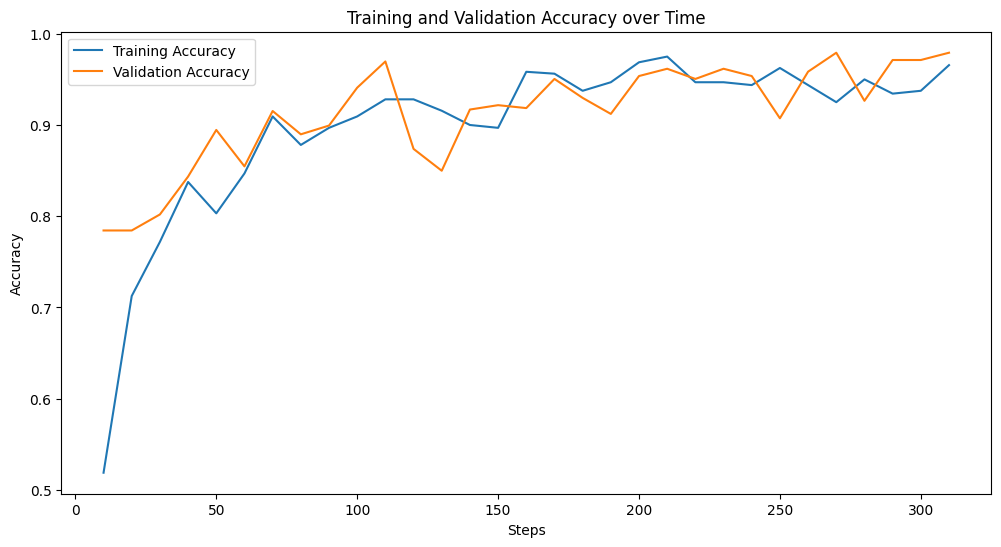

In [ ]:
validation_every_steps = 10
step = 0

# Early stopping initialization
early_stopping = EarlyStopping(patience=5, delta=0.01)

model.train()

train_accuracies = []
valid_accuracies = []
steps_log = []  # Track steps for plotting
val_losses = []  # Initialize val_losses list to track validation loss

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute RAPSD for the batch
        rapsd_vector_batch, _ = compute_rapsd_subset(zip(inputs.cpu(), targets.cpu()))

        # Convert the list of RAPSD vectors to a numpy array
        rapsd_vector_batch = np.array(rapsd_vector_batch)

        # Convert numpy array to PyTorch tensor
        rapsd_vector_batch = torch.from_numpy(rapsd_vector_batch).type(torch.float32).to(device)

        output = model(inputs, rapsd_vector_batch)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            val_loss_total = 0  # Variable to accumulate the validation loss

            with torch.no_grad():
                model.eval()
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    rapsd_vector_batch, _ = compute_rapsd_subset(zip(inputs.cpu(), targets.cpu()))

                    # Convert the list of RAPSD vectors to a numpy array
                    rapsd_vector_batch = np.array(rapsd_vector_batch)

                    rapsd_vector_batch = torch.from_numpy(rapsd_vector_batch).type(torch.float32).to(device)

                    output = model(inputs, rapsd_vector_batch)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                    # Accumulate the loss
                    val_loss_total += loss.item() * len(inputs)  # Multiply by batch size to get total loss

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / val_size)

            # Store the average validation loss for the entire validation set
            avg_val_loss = val_loss_total / val_size
            val_losses.append(avg_val_loss)

            steps_log.append(step)  # Track the step number for plotting

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

    # Pass the average validation loss for the current epoch to the early stopping
    early_stopping(val_losses[-1], model)  # Using the latest validation loss

    # Check if early stop
    if early_stopping.early_stop:
        print("Early stopping")
        break

early_stopping.load_best_model(model)

print("Finished training.")

# Plotting accuracy over training steps
plt.figure(figsize=(12, 6))
plt.plot(steps_log, train_accuracies, label='Training Accuracy')
plt.plot(steps_log, valid_accuracies, label='Validation Accuracy')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Time")
plt.legend()
plt.show()


### Test evaluation

In [ ]:
# Evaluate model

with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        rapsd_vector_batch, _ = compute_rapsd_subset(zip(inputs.cpu(), targets.cpu()))

        # Convert the list of RAPSD vectors to a numpy array
        rapsd_vector_batch = np.array(rapsd_vector_batch)

        rapsd_vector_batch = torch.from_numpy(rapsd_vector_batch).type(torch.float32).to(device)
        output = model(inputs,rapsd_vector_batch)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))


    test_accuracy = np.sum(test_accuracies) / test_size

    model.train()

print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.963


### Things to try
* Creating a specific encoder for RAPSD seperate and then combining with CNN
* Implementing a GRU or other RNN, LSTM for RAPSD
* Attention mechanism? Don't know if this is correct
* Test different datasets
* Focus solely on RAPSD as input?
* Saliency map?
* RGB channel for testing instead of grayscale